In [ ]:
# Kaggle Machine Learning Project by Derian Mowen
# For Advanced Kaggle Competition
# Link: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import pingouin as pg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.stats import boxcox
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', None)

In [ ]:
# Import the Kaggle Training Dataset
Kaggle = pd.read_csv('train.csv')

# Drop LowQualFinSFt due to it being entirely constant with 0 (it will contribute nothing)
# Also drop the target variable so transformations are not applied to SalePrice
sp = Kaggle['SalePrice']
Kaggle = Kaggle.drop(columns=['LowQualFinSF', 'SalePrice'])

# Import the Kaggle Test Dataset
KTest = pd.read_csv('test.csv')
KTest = KTest.drop(columns=['LowQualFinSF'])


# Convert YearBuilt to Age
cur_year = 2024

# Calculate Age from YearBuilt
Kaggle['Age'] = cur_year - Kaggle['YearBuilt']
KTest['Age'] = cur_year - KTest['YearBuilt']

# Now drop the 'YearBuilt' column
Kaggle.drop(columns=['YearBuilt'], inplace=True)
KTest.drop(columns=['YearBuilt'], inplace=True)


In [ ]:
# Determine which variables are categorical and which ones are not by iterating through each variable within the dataset
# Clean each responding variable with similar methods applied to each variable in order to maintain consistency and efficiency
cats = []
nums = []
for column in Kaggle.columns:
    dtype = Kaggle[column].dtype

    # Specific Cases like year due to it being numerical but actually being categorical
    if column == 'Id':
        pass
    elif column == 'MoSold' or column == 'YrSold' or column == 'YearBuilt' or column == 'YearRemodAdd' or column == 'MSSubClass':
        Kaggle[column] = Kaggle[column].astype('str')
        Kaggle[column].fillna(Kaggle[column].mode()[0], inplace=True)
        cats += [column]
        Kaggle[column] = Kaggle[column].astype('category')

        # Count occurrences of each level
        level_counts = Kaggle[column].value_counts()

        # Identify levels with fewer than 10 occurrences
        infrequent_levels = level_counts[level_counts < 10].index

        # Replace infrequent levels with mode
        mode_value = Kaggle[column].mode()[0]
        Kaggle[column] = Kaggle[column].apply(lambda x: mode_value if x in infrequent_levels else x)
    # Determine object is categorical
    if dtype == 'object':
        # print(f"{column} is categorical... cleaning")
        Kaggle[column] = Kaggle[column].astype('str')
        Kaggle[column].fillna(Kaggle[column].mode()[0], inplace=True)
        cats += [column]
        Kaggle[column] = Kaggle[column].astype('category')

        # Count occurrences of each level
        level_counts = Kaggle[column].value_counts()

        # Identify levels with fewer than 10 occurrences
        infrequent_levels = level_counts[level_counts < 10].index

        # Replace infrequent levels with mode
        mode_value = Kaggle[column].mode()[0]
        Kaggle[column] = Kaggle[column].apply(lambda x: mode_value if x in infrequent_levels else x)



    # Determine object is numerical
    elif dtype in ['int64', 'float64']:
        # print(f"{column} is numerical... cleaning")
        # Convert to float and fill missing values with mean
        Kaggle[column] = Kaggle[column].astype('float')
        Kaggle[column].fillna(Kaggle[column].mean(), inplace=True)

        # Calculate z-scores
        z_scores = zscore(Kaggle[(column)])

        # Define a threshold for outliers (e.g., z-score > 3 or < -3)
        threshold = 3

        # Identify and remove outliers with the median
        is_outlier = np.abs(z_scores) >= threshold
        Kaggle.loc[is_outlier, (column)] = Kaggle[column].median()

       #  Kaggle[column] = np.log10(Kaggle[column] + 0.01)

        nums += [column]
    else:
        print(f"{column} is of unrecognized type: {dtype}")

# Apply the same transformations to the test dataset
for column in KTest.columns:
    dtype = KTest[column].dtype

    # Specific Cases like year due to it being numerical but actually being categorical
    if column == 'Id':
        pass
    elif column == 'MoSold' or column == 'YrSold' or column == 'YearBuilt' or column == 'YearRemodAdd' or column == 'MSSubClass':
        KTest[column] = KTest[column].astype('str')
        KTest[column].fillna(KTest[column].mode()[0], inplace=True)
        KTest[column] = KTest[column].astype('category')

                # Count occurrences of each level
        level_counts = KTest[column].value_counts()

        # Identify levels with fewer than 10 occurrences
        infrequent_levels = level_counts[level_counts < 10].index

        # Replace infrequent levels with mode
        mode_value = KTest[column].mode()[0]
    # Determine object is categorical
    if dtype == 'object':
        # print(f"{column} is categorical... cleaning")
        KTest[column] = KTest[column].astype('str')
        KTest[column].fillna(KTest[column].mode()[0], inplace=True)
        KTest[column] = KTest[column].astype('category')

                # Count occurrences of each level
        level_counts = KTest[column].value_counts()

        # Identify levels with fewer than 10 occurrences
        infrequent_levels = level_counts[level_counts < 10].index

        # Replace infrequent levels with mode
        mode_value = KTest[column].mode()[0]


    # Determine object is numerical
    elif dtype in ['int64', 'float64']:
        # print(f"{column} is numerical... cleaning")
        # Convert to float and fill missing values with mean
        KTest[column] = KTest[column].astype('float')
        KTest[column].fillna(KTest[column].mean(), inplace=True)
        # Calculate z-scores
        z_scores = zscore(KTest[(column)])

        # Define a threshold for outliers (e.g., z-score > 3 or < -3)
        threshold = 3

        # Identify and remove outliers with the median
        is_outlier = np.abs(z_scores) >= threshold
        KTest.loc[is_outlier, (column)] = KTest[column].median()
        # Count the number of infinity values in the column

        # KTest[column] = np.log10(KTest[column] + 0.01)

    else:
        print(f"{column} is of unrecognized type: {dtype}")

# Ensure that both datasets have the same columns after preprocessing
common_columns = set(Kaggle.columns).intersection(set(KTest.columns))
Kaggle = Kaggle[common_columns]
KTest = KTest[common_columns]

# Print the length of categorical and numerical columns in both datasets
print("Categorical columns in Kaggle:", cats)
print("Numerical columns in Kaggle:", nums)
print("Length of Kaggle dataset:", len(Kaggle))
print("Length of KTest dataset:", len(KTest))

# Continue with your modeling process...


Categorical columns in Kaggle: ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
Numerical columns in Kaggle: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Firep

C:\Users\bluem\anaconda3\Lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\bluem\AppData\Local\Temp\ipykernel_20916\805388048.py:130: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  Kaggle = Kaggle[common_columns]
C:\Users\bluem\AppData\Local\Temp\ipykernel_20916\805388048.py:131: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  KTest = KTest[common_columns]


In [ ]:
#x_train.isnull().sum()

In [ ]:
# Basic Least Squares Regression Model

# Perform one-hot encoding on the categorical columns to enable them to be used within the basic least squares regression model
Kaggle_encoded = pd.get_dummies(Kaggle, columns=cats)
KTest_encoded = pd.get_dummies(KTest, columns=cats)

# Align columns between training and test datasets
common_columns = set(Kaggle_encoded.columns).intersection(set(KTest_encoded.columns))
Kaggle_encoded = Kaggle_encoded[common_columns]
KTest_encoded = KTest_encoded[common_columns]

x_train = sm.add_constant(Kaggle_encoded)
y_train = sp
model_plain_vanilla = sm.OLS(y_train, x_train).fit()

print(model_plain_vanilla.summary())

# Align columns between training and test datasets
x_test = sm.add_constant(KTest_encoded)

# Predict using the trained model
predicted_values = model_plain_vanilla.predict(x_test)

# Create a DataFrame containing the predicted values
predicted_df = pd.DataFrame({'SalePrice': predicted_values})

# Add the 'Id' column from the test dataset
predicted_df['Id'] = KTest['Id'].astype('int')
print(predicted_df.head(5))
# Save the DataFrame to a CSV file
predicted_df.to_csv('basic_predicted_values.csv', index=False)


C:\Users\bluem\AppData\Local\Temp\ipykernel_20916\982478580.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  Kaggle_encoded = Kaggle_encoded[common_columns]
C:\Users\bluem\AppData\Local\Temp\ipykernel_20916\982478580.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  KTest_encoded = KTest_encoded[common_columns]


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     40.32
Date:                Wed, 20 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:02:36   Log-Likelihood:                -16910.
No. Observations:                1460   AIC:                         3.432e+04
Df Residuals:                    1208   BIC:                         3.566e+04
Df Model:                         251                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
HouseStyle_SLvl        1.298e+

In [ ]:
# Vanilla Best Kaggle Score: 0.20261

In [ ]:
# Multi Collinearity Diagnostic
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Drop columns with non-numeric data types (like object/string)
numeric_Kaggle = Kaggle.select_dtypes(include=['number'])
print(numeric_Kaggle.head(5))


# Calculate VIF for each column in the numeric Kaggle DataFrame
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(numeric_Kaggle.values, i) for i in range(numeric_Kaggle.shape[1])]
vif["Variable"] = numeric_Kaggle.columns

# Filter rows where VIF is greater than 10
high_vif_variables = vif[vif["VIF"] > 10]

# Print variables with VIF greater than 10
print("Variables with VIF > 10:")
for index, row in high_vif_variables.iterrows():
    print(f"{row['Variable']}: {row['VIF']}")



   TotalBsmtSF  EnclosedPorch  YearRemodAdd  2ndFlrSF  WoodDeckSF  GarageArea  \
0        856.0            0.0        2003.0     854.0         0.0       548.0   
1       1262.0            0.0        1976.0       0.0       298.0       460.0   
2        920.0            0.0        2002.0     866.0         0.0       608.0   
3        756.0            0.0        1970.0     756.0         0.0       642.0   
4       1145.0            0.0        2000.0    1053.0       192.0       836.0   

   GrLivArea  MSSubClass  OverallQual  3SsnPorch  ...  OpenPorchSF  MiscVal  \
0     1710.0        60.0          7.0        0.0  ...         61.0      0.0   
1     1262.0        20.0          6.0        0.0  ...          0.0      0.0   
2     1786.0        60.0          7.0        0.0  ...         42.0      0.0   
3     1717.0        70.0          7.0        0.0  ...         35.0      0.0   
4     2198.0        60.0          8.0        0.0  ...         84.0      0.0   

   Fireplaces  BsmtUnfSF  LotFrontage 

C:\Users\bluem\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


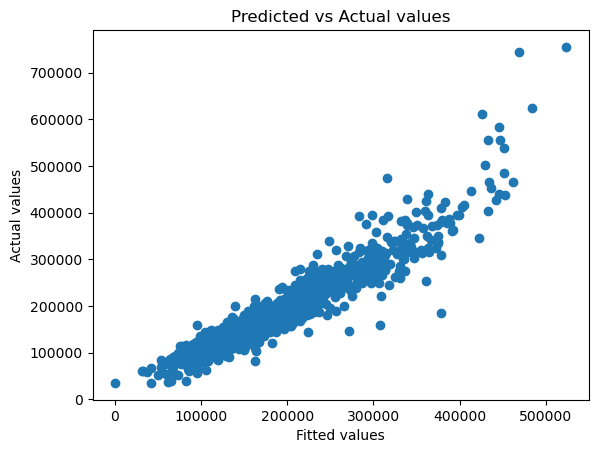

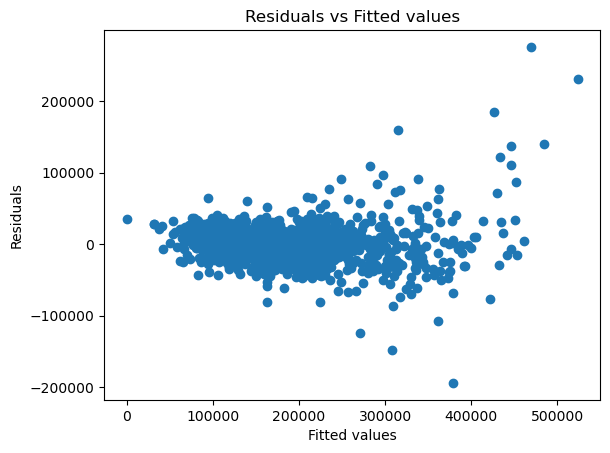

In [ ]:
# Non Linearity Check
import matplotlib.pyplot as plt

# Assuming model is your fitted linear regression model
# Plotting residuals vs. each independent variable
# Plotting predicted vs actual values
plt.scatter(model_plain_vanilla.fittedvalues, y_train)
plt.xlabel('Fitted values')
plt.ylabel('Actual values')
plt.title('Predicted vs Actual values')
plt.show()

# Plotting residuals vs fitted values
plt.scatter(model_plain_vanilla.fittedvalues, model_plain_vanilla.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.show()



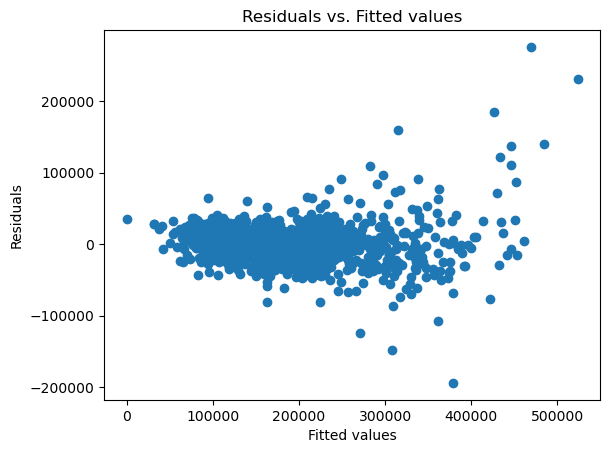

In [ ]:
# Heteroscedasticity
# Plotting residuals vs. fitted values
plt.scatter(model_plain_vanilla.fittedvalues, model_plain_vanilla.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted values')
plt.show()

# Log 10 transformation due to fan pattern

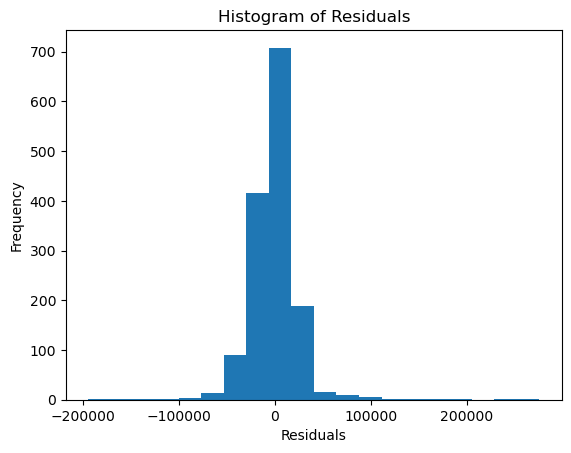

In [ ]:
# Normality Check
import scipy.stats as stats

# Plotting histogram of residuals
plt.hist(model_plain_vanilla.resid, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


In [ ]:
# Apply changes to fix assumptions specifically Heteroscedasticity and vif columns

# Fix
variables_to_transform = Kaggle.select_dtypes(include=['number'])
print(variables_to_transform.columns)

colstodrop = ['MoSold','YrSold','YearRemodAdd', 'Id', 'GarageYrBlt']
variables_to_transform.drop(columns=colstodrop, inplace=True)

# Iterate through each column in the DataFrame

for col in variables_to_transform:
    Kaggle[col] = Kaggle[col].apply(lambda x: x + 0.01)
    KTest[col] = KTest[col].apply(lambda x: x + 0.01)

KaggleP = Kaggle.apply(lambda x: np.log10(x) if x.name in variables_to_transform else x)

# Do the same thing for test data set

KTestP = KTest.apply(lambda x: np.log10(x) if x.name in variables_to_transform else x)

# SP


# New Model
# Perform one-hot encoding on the categorical columns to enable them to be used within the basic least squares regression model
KaggleP_encoded = pd.get_dummies(KaggleP, columns=cats)
KTestP_encoded = pd.get_dummies(KTestP, columns=cats)

# Fix vif
# Drop 'KitchenAbvGr' column from Kaggle DataFrame
KaggleP.drop(columns=['KitchenAbvGr'], inplace=True)

# Drop 'KitchenAbvGr' column from KTest DataFrame
KTestP.drop(columns=['KitchenAbvGr'], inplace=True)


# Align columns between training and test datasets
common_columns = set(KaggleP_encoded.columns).intersection(set(KTest_encoded.columns))
Kaggle_encoded = KaggleP_encoded[common_columns]
KTest_encoded = KTestP_encoded[common_columns]

x_train = sm.add_constant(Kaggle_encoded)
y_train = np.log10(y_train)
model_plain_vanilla = sm.OLS(y_train, x_train).fit()

print(model_plain_vanilla.summary())

# Align columns between training and test datasets
x_test = sm.add_constant(KTest_encoded)

# Predict using the trained model
predicted_values = model_plain_vanilla.predict(x_test)

# Create a DataFrame containing the predicted values
predicted_df = pd.DataFrame({'SalePrice': predicted_values})

# Add the 'Id' column from the test dataset
predicted_df['Id'] = KTestP['Id'].astype('int')
predicted_df['SalePrice'] = 10**predicted_df['SalePrice']
print(predicted_df.head(5))
# Save the DataFrame to a CSV file
predicted_df.to_csv('prescriptions_predicted_values.csv', index=False)

Index(['TotalBsmtSF', 'EnclosedPorch', 'YearRemodAdd', '2ndFlrSF',
       'WoodDeckSF', 'GarageArea', 'GrLivArea', 'MSSubClass', 'OverallQual',
       '3SsnPorch', 'GarageCars', 'BsmtHalfBath', 'MoSold', 'LotArea',
       'PoolArea', 'GarageYrBlt', 'ScreenPorch', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'Age', 'TotRmsAbvGrd', 'MasVnrArea', 'Id', 'BsmtFinSF1',
       'OverallCond', 'OpenPorchSF', 'MiscVal', 'Fireplaces', 'BsmtUnfSF',
       'LotFrontage', 'KitchenAbvGr', 'BedroomAbvGr', '1stFlrSF', 'YrSold',
       'BsmtFinSF2'],
      dtype='object')


C:\Users\bluem\AppData\Local\Temp\ipykernel_20916\2858249350.py:40: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  Kaggle_encoded = KaggleP_encoded[common_columns]
C:\Users\bluem\AppData\Local\Temp\ipykernel_20916\2858249350.py:41: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  KTest_encoded = KTestP_encoded[common_columns]


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     62.77
Date:                Wed, 20 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:02:41   Log-Likelihood:                 2378.6
No. Observations:                1460   AIC:                            -4275.
Df Residuals:                    1219   BIC:                            -3001.
Df Model:                         240                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
HouseStyle_SLvl           0.01

In [ ]:
# Diagnostic Best Kaggle Score: 0.16599

In [ ]:
# Forward Selection Using AIC and BIC
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Change these variables to apply code
train = x_train


lr = LinearRegression()
model_forward = sfs(estimator=lr,k_features=(1,train.shape[1]),forward=True, scoring='r2',cv= None)
model_forward = model_forward.fit(x_train, y_train)


forward_predictor_dict = {}
for num_predictors in range(1,train.shape[1]):
    specific_predictors = list(model_forward.subsets_[num_predictors]['feature_names'])
    key = f'{num_predictors}_predictor'
    forward_predictor_dict[key] = specific_predictors



# Extract the keys

forward_predictor_dict_keys = list(forward_predictor_dict.keys())


forward_AIC = []
for i in forward_predictor_dict_keys:
    results_forward = sm.OLS(y_train, sm.add_constant(train[forward_predictor_dict[i]])).fit()
    forward_AIC.append(results_forward.aic)

# Pick the model with the LOWEST AIC
forward_index_of_lowest_AIC = forward_AIC.index(min(forward_AIC))



# Generate Model with selected features 5 predictor name is not accurate
Best_33_predictor_forward_AIC = forward_predictor_dict['33_predictor']
x_train_forward_AIC = sm.add_constant(train[Best_33_predictor_forward_AIC])
model_forward_AIC = sm.OLS(y_train, x_train_forward_AIC).fit()

# Align columns between training and test datasets
x_test = sm.add_constant(KTest_encoded[Best_33_predictor_forward_AIC])

# Predict using the trained model
predicted_values = model_forward_AIC.predict(x_test)

# Create a DataFrame containing the predicted values
predicted_df = pd.DataFrame({'SalePrice': predicted_values})

# Add the 'Id' column from the test dataset
predicted_df['Id'] = KTest['Id'].astype('int')
print(predicted_df.head(5))
predicted_df['SalePrice'] = 10**predicted_df['SalePrice']
# Save the DataFrame to a CSV file
predicted_df.to_csv('forwardaic_predicted_values.csv', index=False)


   SalePrice    Id
0   5.086340  1461
1   5.220829  1462
2   5.249210  1463
3   5.311179  1464
4   5.322139  1465


In [ ]:
# Forward AIC Best Kaggle Score: 0.14354

In [ ]:
# Backward BIC

lr = LinearRegression()
model_backward = sfs(lr,k_features = (1,train.shape[1]), forward=False, scoring='r2',cv= None)
model_backward = model_backward.fit(train, y_train)
model_backward.subsets_

# Write a loop to create a dictionary that stores selected features of the best model of each size.
backward_predictor_dict = {}
for num_predictors in range(1,train.shape[1]):
    specific_predictors = list(model_backward.subsets_[num_predictors]['feature_names'])
    key = f'{num_predictors}_predictor'
    backward_predictor_dict[key] = specific_predictors


# Exact the keys
backward_predictor_dict_keys = list(backward_predictor_dict.keys())

backward_BIC = []
for i in backward_predictor_dict_keys:
    results_backward = sm.OLS(y_train, sm.add_constant(train[backward_predictor_dict[i]])).fit()
    backward_BIC.append(results_backward.bic)

# Pick the model with the LOWEST BIC
print(backward_BIC)
backward_index_of_lowest_BIC = backward_BIC.index(min(backward_BIC))
print(backward_predictor_dict_keys[backward_index_of_lowest_BIC])

#Use the best 5-predictor model to compute training and test MSE
Best_33_predictor_backward_BIC = backward_predictor_dict['33_predictor']
x_train_backward_BIC = sm.add_constant(train[Best_33_predictor_backward_BIC])
model_backward_BIC = sm.OLS(y_train, x_train_backward_BIC).fit()


# Align columns between training and test datasets
x_test = sm.add_constant(KTest_encoded[Best_33_predictor_backward_BIC])

sm.add_constant(KTest_encoded)

# Predict using the trained model
predicted_values = model_backward_BIC.predict(x_test)

# Create a DataFrame containing the predicted values
predicted_df = pd.DataFrame({'SalePrice': predicted_values})

# Add the 'Id' column from the test dataset
predicted_df['Id'] = KTest['Id'].astype('int')
predicted_df['SalePrice'] = 10**predicted_df['SalePrice']
print(predicted_df.head(5))
# Save the DataFrame to a CSV file
predicted_df.to_csv('backwardbic_predicted_values.csv', index=False)


[-2405.4655386187055, -2815.654884723825, -3005.3222632319853, -3232.1585734869313, -3418.520955272808, -3532.94145820633, -3533.204735022379, -3630.3943097452084, -3686.237004480432, -3739.993245867006, -3769.8644915186132, -3797.306415179603, -3834.128011195986, -3862.797895920217, -3889.853675188993, -3911.02693298774, -3929.3472477488126, -3941.4410919351612, -3954.0421507242295, -3967.6785720756443, -3980.8170702240013, -3983.683229578161, -3986.6086377580523, -3990.1363429807075, -3999.566618048043, -4004.958018146978, -4010.4728223770726, -4013.1721242827825, -4016.801674546526, -4021.755611958867, -4026.267494317079, -4033.9447101798414, -4041.6941412381852, -4048.47589278242, -4052.6091750838486, -4059.602925431344, -4066.8018793376887, -4069.0539023497763, -4076.487024389843, -4079.866905576885, -4083.282607020458, -4082.532403149453, -4082.101548359194, -4083.639814052586, -4084.461463322765, -4081.154616582029, -4080.083445568971, -4081.319762994733, -4082.444891767899, -40

In [ ]:
# Backward BIC best kaggle score: 0.15502

In [ ]:
# Ridge Regression

from sklearn.linear_model import Ridge # Import Ridge algorithm

# Import the algorithm that can perform grid search and cross-validation simultaneously.
from sklearn.model_selection import GridSearchCV
# Import KFold algorithm to sepcify how data is split for cross-validation.
from sklearn.model_selection import KFold


model_ridge = Ridge()

# Define cross-validation data splitting strategy
kf_ridge = KFold(n_splits = 10, shuffle = True, random_state = 42)


# Specify the range of alpha

grid_ridge = {'alpha' : np.logspace(start = -8, stop = 8, num = 100, base = 10)}


# Excecute cross-validation for each alpha value in the grid
cv_ridge = GridSearchCV(estimator = model_ridge,
                        param_grid = grid_ridge,
                        scoring = 'neg_mean_squared_error',
                        cv = kf_ridge)

cv_ridge.fit(x_train, y_train)
# Output the best alpha and the corresponding cross-validation score
print(cv_ridge.best_params_, cv_ridge.best_score_)
# Best Ridge Model
model_ridge_best = Ridge(alpha = 2.5353644939701168).fit(train, y_train)

# Predict the target variable for the test dataset

x_test = sm.add_constant(KTest_encoded)

predicted_values_ridge = model_ridge_best.predict(x_test)

# Create a DataFrame containing the predicted values
predicted_df = pd.DataFrame({'SalePrice': predicted_values_ridge})

# Add the 'Id' column from the test dataset
predicted_df['Id'] = KTest['Id'].astype(int)
predicted_df['SalePrice'] = 10**predicted_df['SalePrice']
# Print the first 5 rows of the DataFrame
print(predicted_df.head())

# Save the DataFrame to a CSV file
predicted_df.to_csv('ridge_predicted_values.csv', index=False)


C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.09914e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.24552e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.11346e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.31574e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:20

C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.44253e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


{'alpha': 2.5353644939701168} -0.0036433475448784253
       SalePrice    Id
0  126409.300181  1461
1  160219.305055  1462
2  181997.583273  1463
3  199469.456593  1464
4  189502.596856  1465


In [ ]:
# Ridge Best Kaggle Score: 0.14365

In [ ]:
# Lasso Regression
from sklearn.linear_model import Lasso


# Define the Lasso estimator
model_Lasso = Lasso()

# Define cross-validation data splitting strategy
kf_Lasso = KFold(n_splits = 10, shuffle = True, random_state = 42)

# Define the search range for alpha

grid_Lasso = {'alpha' : np.logspace(start = -8, stop = 8, num = 100, base = 10)}

# Excecute cross-validation for each alpha value in the grid

cv_Lasso = GridSearchCV(estimator = model_Lasso,
                        param_grid = grid_Lasso,
                        scoring = 'neg_mean_squared_error',
                        cv = kf_Lasso)
cv_Lasso.fit(train, y_train)
#Output the best alpha and the corresponding score
print(cv_Lasso.best_params_, cv_Lasso.best_score_)

#After the best alpha is determined, run Lasso regression on the training set using the best alpha.
model_Lasso_best = Lasso(alpha = 0.00023101297000831627).fit(train, y_train)

# Predict the target variable for the test dataset
x_test = sm.add_constant(KTest_encoded)

predicted_values_Lasso = model_Lasso_best.predict(x_test)

# Create a DataFrame containing the predicted values
predicted_df = pd.DataFrame({'SalePrice': predicted_values_Lasso})

# Add the 'Id' column from the test dataset
predicted_df['Id'] = KTest['Id'].astype(int)
predicted_df['SalePrice'] = 10**predicted_df['SalePrice']
# Print the first 5 rows of the DataFrame
print(predicted_df.head())

# Save the DataFrame to a CSV file
predicted_df.to_csv('lasso_predicted_values.csv', index=False)

C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.441e+00, tolerance: 3.851e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e+00, tolerance: 3.899e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e+00, toleranc

C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e+00, tolerance: 3.986e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e+00, tolerance: 4.019e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.397e+00, toleranc

C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.429e+00, tolerance: 4.005e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e+00, tolerance: 4.030e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.429e+00, toleranc

C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+00, tolerance: 4.020e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.390e+00, tolerance: 3.901e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.411e+00, toleranc

C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.358e+00, tolerance: 3.802e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.427e+00, tolerance: 4.003e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e+00, toleranc

C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.408e+00, tolerance: 3.851e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.405e+00, tolerance: 3.899e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.452e+00, toleranc

C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.385e+00, tolerance: 3.986e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.423e+00, tolerance: 4.019e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e+00, toleranc

C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.436e+00, tolerance: 4.005e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.513e+00, tolerance: 4.030e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e+00, toleranc

C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.960e-01, tolerance: 4.020e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.145e-01, tolerance: 3.901e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.197e-01, toleranc

C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.387e-02, tolerance: 3.802e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.070e-01, tolerance: 4.003e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.736e-02, toleranc

C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.952e-03, tolerance: 4.020e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.257e-03, tolerance: 3.901e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\bluem\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.186e-01, toleranc

{'alpha': 0.00023101297000831627} -0.0034227359317582882
       SalePrice    Id
0  116504.756300  1461
1  163709.444080  1462
2  178231.065951  1463
3  196125.666318  1464
4  197412.477468  1465


In [ ]:
# Lasso Best Kaggle Score: 0.13654

In [ ]:
# Get the coefficients of the Lasso model
coefficients = model_Lasso_best.coef_

# Create a DataFrame to store the coefficients along with their corresponding feature names
feature_coefficients = pd.DataFrame({'Feature': train.columns, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of coefficients to identify the most important features
feature_coefficients_sorted = feature_coefficients.reindex(feature_coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Print the top N most important features
N = 50  # You can adjust this value to print more or fewer features
print(f'Top {N} most important features:')
print(feature_coefficients_sorted.head(N))

# Print the bottom N least important features
print(f'\nBottom {N} least important features:')
print(feature_coefficients_sorted.tail(N))

Top 50 most important features:
                   Feature  Coefficient
42             OverallQual     0.267171
19               GrLivArea     0.228107
251               1stFlrSF     0.182937
198            OverallCond     0.142977
35        MSZoning_C (all)    -0.123454
120                LotArea     0.080426
172   Neighborhood_NoRidge     0.063256
67    Neighborhood_Crawfor     0.052492
47    Neighborhood_StoneBr     0.047685
259         KitchenQual_Ex     0.043574
89             BsmtQual_Ex     0.030988
153   Neighborhood_NridgHt     0.030188
170    Exterior1st_BrkFace     0.029766
190           TotRmsAbvGrd     0.028356
13          Functional_Typ     0.028228
275        BsmtExposure_Gd     0.027226
71              GarageCars     0.026930
197  SaleCondition_Abnorml    -0.024879
176                    Age    -0.024705
146   Neighborhood_Edwards    -0.024614
257           ExterCond_Fa    -0.024169
30    Neighborhood_Somerst     0.022523
276   Neighborhood_ClearCr     0.021577
152     

In [ ]:
# Random Forest Bagging

from sklearn.ensemble import RandomForestRegressor # import the function for Bagging and Random Forest

# Define the Random Forest Regressor
Tree_Bagging = RandomForestRegressor(n_estimators = 500,
                                     criterion = 'squared_error',
                                     max_features = train.shape[1],
                                     bootstrap = True,
                                     max_samples = train.shape[0],
                                     random_state = 42)


# 3.3 Fit a bagged regression tree
Tree_Bagging.fit(train, y_train)


RSS_reduction = Tree_Bagging.feature_importances_
feature_importance_dict = {'feature_name': train.columns, 'RSS_reduction': RSS_reduction}
feature_importance_df = pd.DataFrame(feature_importance_dict).sort_values(by = 'RSS_reduction', ascending=False)


# redefine x test
x_test = sm.add_constant(KTest_encoded)

# Predict the target variable for the training dataset
predicted_values_bagging = Tree_Bagging.predict(x_test)

# Create a DataFrame containing the predicted values
predicted_df = pd.DataFrame({'SalePrice': predicted_values_bagging})

# Add the 'Id' column from the test dataset
predicted_df['Id'] = KTest['Id'].astype(int)
predicted_df['SalePrice'] = 10**predicted_df['SalePrice']
# Print the first 5 rows of the DataFrame
print(predicted_df.head())

# Save the DataFrame to a CSV file
predicted_df.to_csv('bagging_predicted_values.csv', index=False)

       SalePrice    Id
0  127598.906712  1461
1  154428.799094  1462
2  175679.160642  1463
3  180564.183367  1464
4  197104.183583  1465


In [ ]:
# Bagging Best Kaggle Score: 0.15218

In [ ]:
# Random Forest

# Define x matrix and y matrix

# 4.2 Grow a random forest
Tree_RF = RandomForestRegressor(n_estimators = 500,
                           criterion = 'squared_error',
                           max_features = 6,
                           bootstrap = True,
                           max_samples = train.shape[0],
                           random_state = 42)


# A loop to find the opimal max_features value

# Split training data into sub-training and sub-test sets using a 75-25 split.

newtrain = train
newtrain['SalePrice'] = sp
sub_train, sub_test = train_test_split(newtrain, train_size = 0.75, test_size= 0.25, random_state= 123)

x_sub_train = sub_train
y_sub_train = sub_train['SalePrice']

x_sub_test = sub_test
y_sub_test = sub_test['SalePrice']

max_features = []
subtest_mse_rf = []
for i in range(1, 12):
    Tree_RF = RandomForestRegressor(n_estimators = 500,
                                    criterion = 'squared_error',
                                    max_features = i,
                                    bootstrap = True,
                                    max_samples = x_sub_train.shape[0],
                                    random_state = 42)
    Tree_RF.fit(x_sub_train, y_sub_train)
    max_features.append(i)
    subtest_mse_rf.append(mean_squared_error(y_sub_test, Tree_RF.predict(x_sub_test)))

# Create a data frame to store max_features and subtest_mse_rf and sort the data frame by subtest_mse_rf.
df = pd.DataFrame({'max_features': max_features, 'subtest_mse_rf': subtest_mse_rf}).sort_values(by = 'subtest_mse_rf')

Tree_RF_Best = RandomForestRegressor(n_estimators = 500,
                           criterion = 'squared_error',
                           max_features = 3,
                           bootstrap = True,
                           max_samples = train.shape[0],
                           random_state = 42)
# Remove the 'SalePrice' column from the training data
newtrain = newtrain.drop(columns=['SalePrice'])

# Fit the best random forest model
Tree_RF_Best.fit(newtrain, y_train)
# Predict using the trained model
predicted_values = Tree_RF_Best.predict(KTest_encoded)

# Create a DataFrame containing the predicted values
predicted_df = pd.DataFrame({'SalePrice': predicted_values})

# Add the 'Id' column from the test dataset
predicted_df['Id'] = KTest['Id'].astype(int)
predicted_df['SalePrice'] = 10**predicted_df['SalePrice']
# Print the first 5 rows of the DataFrame
print(predicted_df.head(5))

# Save the DataFrame to a CSV file
predicted_df.to_csv('randomforest_predicted_values.csv', index=False)

       SalePrice    Id
0  130312.898021  1461
1  153466.399095  1462
2  185427.109863  1463
3  197066.958387  1464
4  190083.102898  1465


In [ ]:
# Random Forest Best Kaggle Score: 0.17894

In [ ]:
# Random Tree with boosting

from sklearn.ensemble import GradientBoostingRegressor


# Define the GradientBoostingRegressor
Tree_Boosting = GradientBoostingRegressor(learning_rate = 0.01,
                                              n_estimators = 1000,
                                              criterion = 'squared_error',
                                              max_leaf_nodes = 5,
                                              max_features = x_train.shape[1],
                                              random_state = 42)

# Fit the tree
Tree_Boosting.fit(x_train, y_train)


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Define cross-validation data splitting strategy
kf_boosting = KFold(n_splits = 2, shuffle = True, random_state = 42)

# Define a grid of possible values for each parameter

param_grid_boosting = {
    'n_estimators': list(range(100, 500, 100)),
    'max_leaf_nodes': [2, 3, 4, 5, 6, 7]
}

Tree_Boosting_best = GradientBoostingRegressor(learning_rate = 0.01,
                                              n_estimators = 1200,
                                              criterion = 'squared_error',
                                              max_leaf_nodes = 6,
                                              max_features = 12,
                                              random_state = 42)


# Define the estimator
Tree_Boosting = GradientBoostingRegressor(learning_rate = 0.01,
                                          criterion = 'squared_error',
                                          max_features = x_train.shape[1],
                                          random_state = 42)

# Excecute cross-validation for all combinations to find the set of parameters
cv_tree_boosting = GridSearchCV(estimator = Tree_Boosting,
                              param_grid = param_grid_boosting,
                              scoring = 'neg_mean_squared_error',
                              cv = kf_boosting,
                              n_jobs = -1)

cv_tree_boosting.fit(x_train, y_train)
print("Best Parameters: ", cv_tree_boosting.best_params_)
print("Best Score: ", cv_tree_boosting.best_score_)

# Fit a boosted regression tree

Tree_Boosting_best = GradientBoostingRegressor(learning_rate = 0.01,
                                              n_estimators = 400,
                                              criterion = 'squared_error',
                                              max_leaf_nodes = 6,
                                              max_features = 12,
                                              random_state = 42)


Tree_Boosting_best.fit(x_train, y_train)

# Output feature importance
RSS_reduction = Tree_Boosting_best.feature_importances_

# Create a feature importance data frame
feature_importance_dict = {'feature_name': x_train.columns, 'RSS_reduction': RSS_reduction}
feature_importance_df = pd.DataFrame(feature_importance_dict).sort_values(by = 'RSS_reduction', ascending=False)


# Predict the target variable for the training dataset
predicted_values_boosting = Tree_Boosting_best.predict(KTest_encoded)

# Create a DataFrame containing the predicted values
predicted_df = pd.DataFrame({'SalePrice': predicted_values_boosting})

# Add the 'Id' column from the test dataset
predicted_df['Id'] = KTest['Id'].astype(int)
predicted_df['SalePrice'] = 10**predicted_df['SalePrice']
# Print the first 5 rows of the DataFrame
print(predicted_df.head())

# Save the DataFrame to a CSV file
predicted_df.to_csv('boosting_predicted_values.csv', index=False)


Best Parameters:  {'max_leaf_nodes': 7, 'n_estimators': 400}
Best Score:  -0.00421804027491203
       SalePrice    Id
0  128719.389957  1461
1  149650.267028  1462
2  187636.306649  1463
3  194076.533958  1464
4  183268.709641  1465


In [ ]:
# Boosting Best Kaggle Score: 0.16928